Affine transformation refinement inspired by Giulio Guzzinati

https://arxiv.org/abs/1902.06979

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import libertem.api as lt
import libertem.udf.blobfinder as blb
import libertem.analysis.gridmatching as grm
import libertem.udf.logsum as logsum
# This extra requires hdbscan, which is an optional dependency
import libertem.analysis.fullmatch as fm
import libertem.viz as viz

In [5]:
ctx = lt.Context()

In [6]:
ds = ctx.load(
    'ser',
    path=r'C:/Users/weber/Nextcloud/Projects/Open Pixelated STEM framework/Data/Xiankui/NBED-R3/NBED-R3-map_1.ser'
)

In [7]:
(y, x) = ds.shape.nav
(fy, fx) = ds.shape.sig

In [8]:
# Sum of log-scaled frames, which highlights weak peaks that are present in many frames
logsum_result = logsum.run_logsum(ctx, ds)

In [9]:
peakfind_params = dict(
    radius=10.0,
    padding=1,
    mask_type='radial_gradient',
    num_disks=40
)

r = peakfind_params['radius']

# Find peaks in the logsum frame
found_peaks = blb.get_peaks(parameters=peakfind_params, sum_result=logsum_result['logsum'].data)

# We use virtual vectors and virtual non-integer indices
zero = found_peaks[0]
a = np.array((1, 0))
b = np.array((0, 1))
virtual_indices = grm.get_indices(found_peaks, zero=zero, a=a, b=b)

<IPython.core.display.Javascript object>


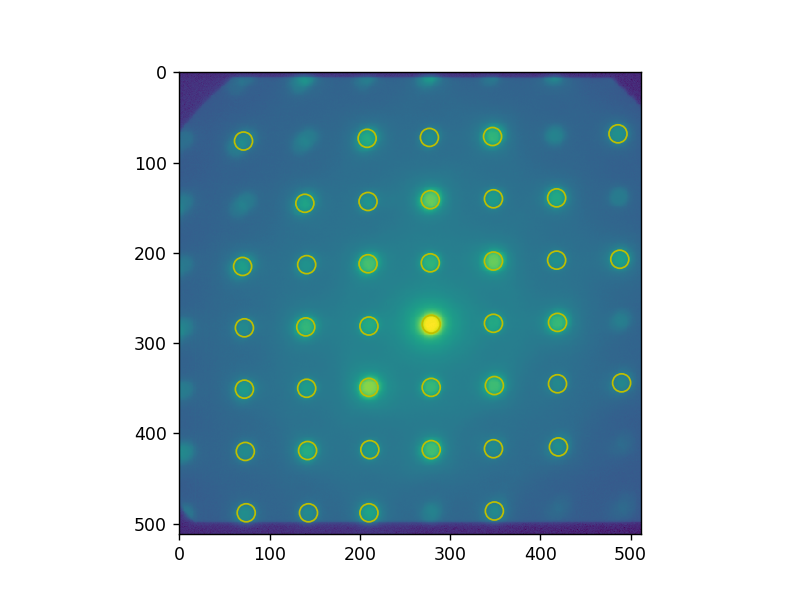

In [10]:
# Visualize found peaks and lattice match
fig, axes = plt.subplots()
axes.imshow(logsum_result['logsum'].data)

for p in np.flip(found_peaks, axis=1):
    axes.add_artist(plt.Circle(p, r, color="y", fill=False))

In [11]:
(transformation, indices) = blb.run_refine(
    ctx, ds, zero=zero, a=a, b=b, 
    corr_params=peakfind_params, 
    match_params={'affine': True}, 
    indices=virtual_indices
)

In [12]:
zeros = transformation['zero'].data
aas = transformation['a'].data
bbs = transformation['b'].data

In [13]:
polar_zeros = grm.make_polar(zeros)
polar_aas = grm.make_polar(aas)
polar_bbs = grm.make_polar(bbs)

<IPython.core.display.Javascript object>


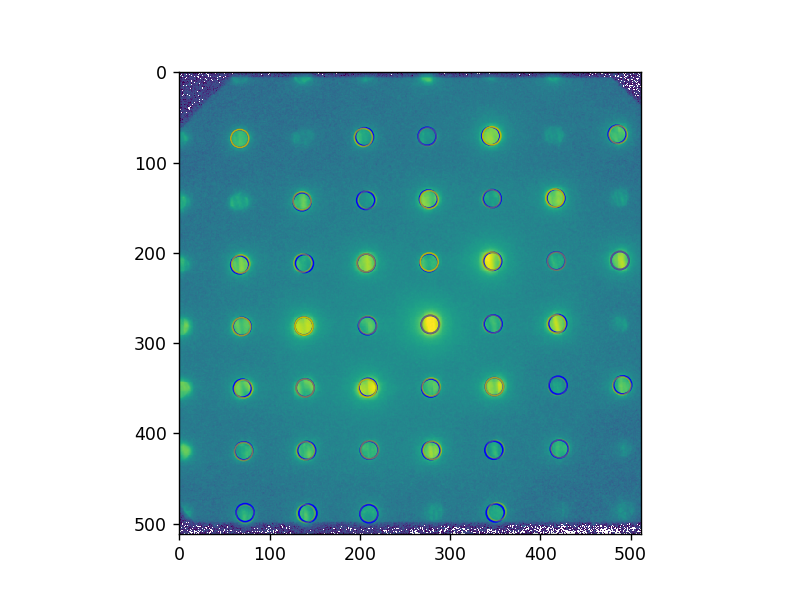

c:\users\weber\appdata\local\conda\conda\envs\libertem\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
c:\users\weber\appdata\local\conda\conda\envs\libertem\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [14]:
# Visualize the refinement of a specific frame
fig, axes = plt.subplots()

pick_y = 7
pick_x = 6

# Get the frame from the dataset
get_sample_frame = ctx.create_pick_analysis(dataset=ds, y=pick_y, x=pick_x)
sample_frame = ctx.run(get_sample_frame)

axes.imshow(np.log(sample_frame[0].raw_data + 1))

sample_refined_fit = transformation['refineds'].data[pick_y, pick_x]
sample_elevations = transformation['peak_elevations'].data[pick_y, pick_x]

max_elevation = np.max(sample_elevations)

# Calclate the best fit positions to compare with the
# individual peak positions.
# A difference between best fit and individual peaks highlights outliers.
calculated = grm.calc_coords(
    zero=zeros[pick_y, pick_x],
    a=aas[pick_y, pick_x],
    b=bbs[pick_y, pick_x],
    indices=virtual_indices
)

# Plot markers for the calculated positions
for i in range(len(calculated)):
    p = np.flip(calculated[i])
    axes.add_artist(plt.Circle(p, r, color="b", fill=False))

# Plot markers for the individual peak positions.
# The alpha channel represents the peak elevation, which is used as a weight in the fit.
for i in range(len(sample_refined_fit)):
    p = np.flip(sample_refined_fit[i])
    a = max(0, sample_elevations[i] / max_elevation)
    axes.add_artist(plt.Circle(p, r, color="y", fill=False, alpha=a))

<IPython.core.display.Javascript object>


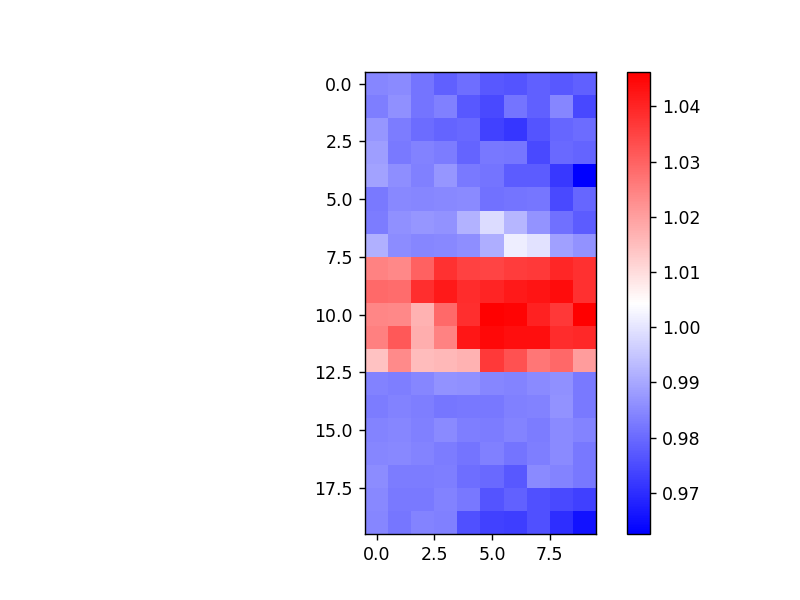

In [15]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(polar_bbs[...,0] / polar_aas[...,0], cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


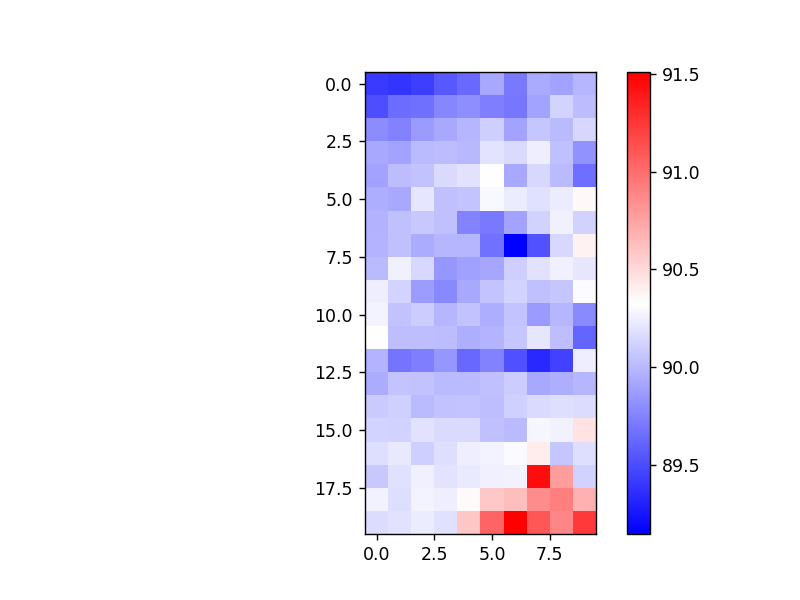

In [16]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[...,1] - polar_bbs[...,1])*180/np.pi, cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


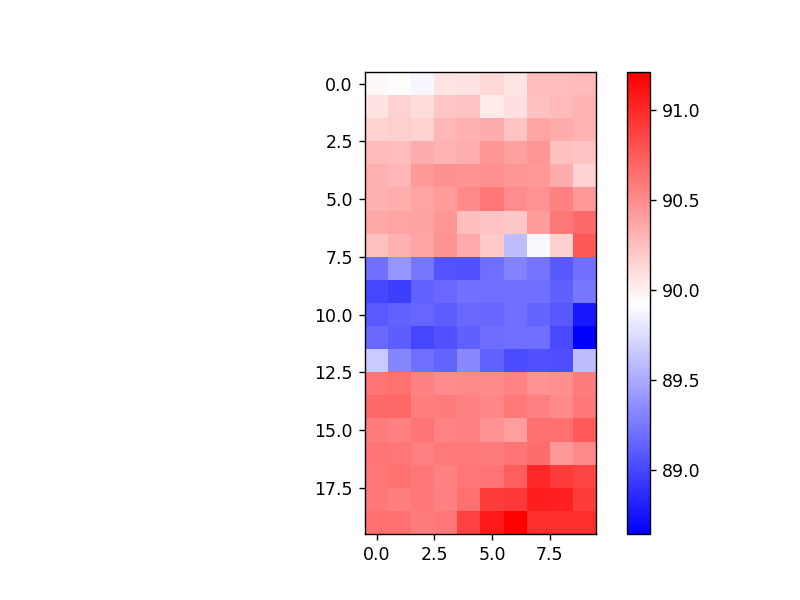

In [17]:
fig, axes = plt.subplots()
# Orientation of "a" vector
plt.imshow(polar_aas[...,1]*180/np.pi, cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


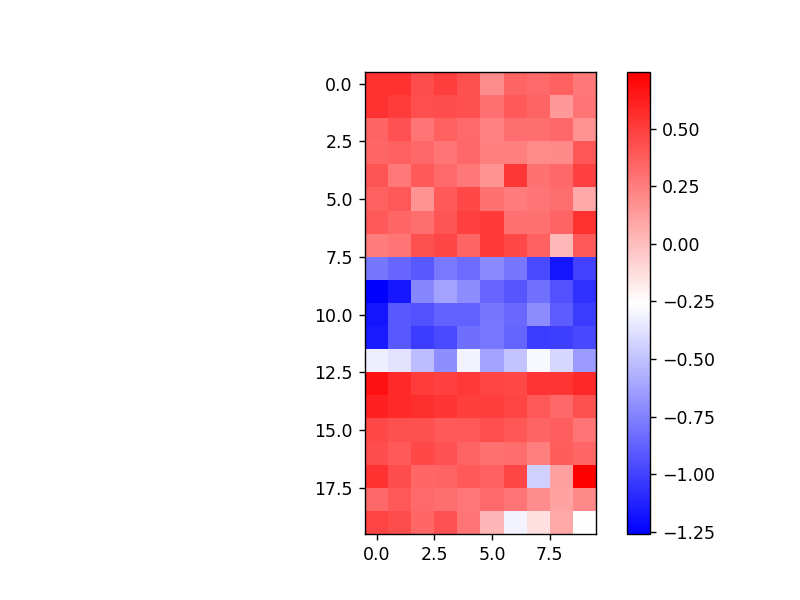

In [18]:
fig, axes = plt.subplots()
plt.imshow(polar_bbs[...,1]*180/np.pi, cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


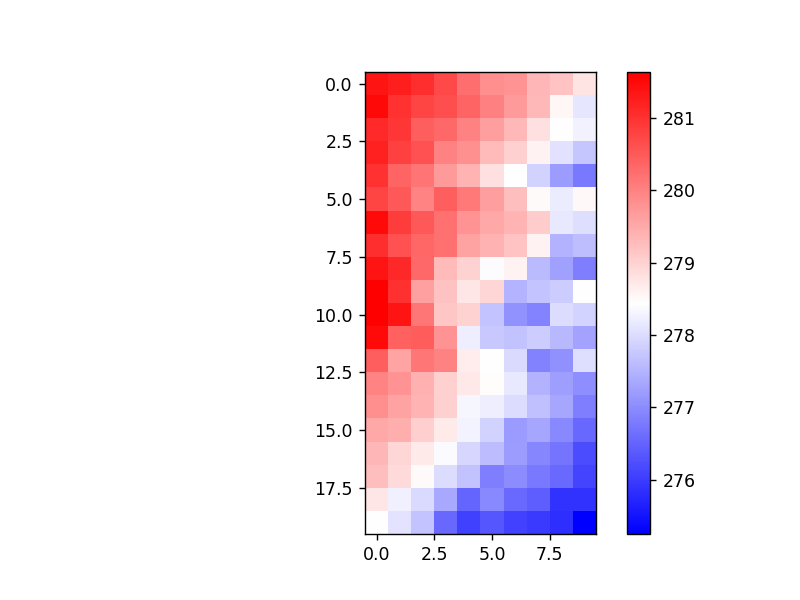

In [19]:
fig, axes = plt.subplots()
# Shift of the y component of the zero point
# Shifts of the zero point might reveal electromagnetic fields under some conditions.
plt.imshow(zeros[...,0], cmap=cm.bwr)
plt.colorbar()

In [20]:
# Fit the zero position with a linear gradient to approximate descan error
positions = np.concatenate(np.mgrid[0:x, 0:y].T)
fit_indices = np.hstack([np.ones([len(positions), 1]), positions])
(fit, residuals, rank, s) = np.linalg.lstsq(fit_indices, zeros.reshape(-1, 2), rcond=None)

In [21]:
# Substract best fit linear gradient from zero point positions
gradient = np.dot(fit_indices, fit).reshape(y, x, 2)
diff = zeros - gradient

<IPython.core.display.Javascript object>


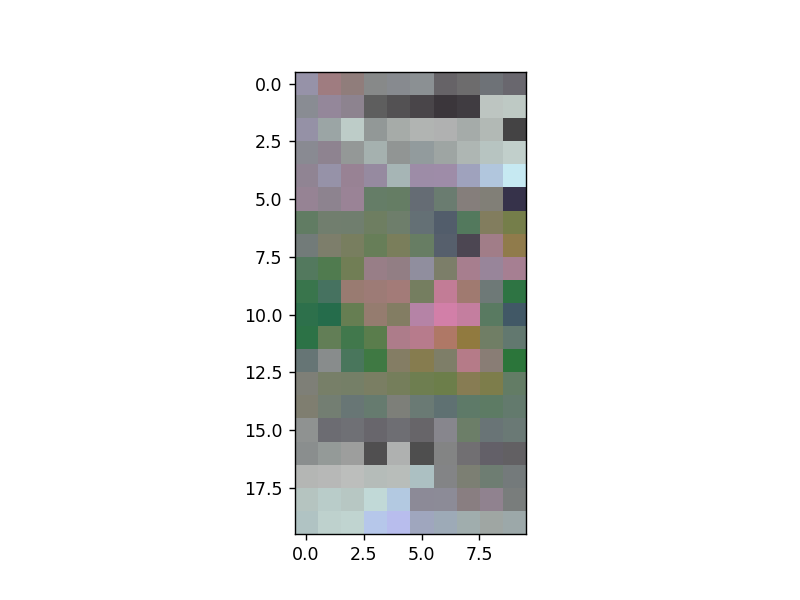

In [22]:
cmap = viz.ColormapCubehelix()
fig, axes = plt.subplots()
# Shift of the zero point visualized with cubehelix 2D color map
plt.imshow(cmap.rgb_from_vector((diff[..., 1], diff[..., 0])))